# CP 2025-26: Assignment 7 - Boundary value problems (Shooting method)

### General Guidelines

> ⚠️⚠️⚠️ READ CAREFULLY ⚠️⚠️⚠️

- Do not add, delete or create cells, write the answer only in the space marked with the three dots (`...`). Where function skeletons are provided, it is assumed that that function can be called again with different inputs somewhere else. So be careful to write code outside of functions.
  - Function should be ['pure'](https://en.wikipedia.org/wiki/Pure_function), thus no side effects, unless otherwise specified.
- Run the the first cell to import all libraries when opening the notebook before running your own code.
- Read carefully what is required to be printed/returned/plotted in the answer. Please do not output what is not asked for. 
  - If you used the print function for debugging, comment it out ( Ctlr + / ) before submitting
- All plots should have title, xlabel, ylabel, and legend (if there are more than one curve on the plot)
- Use the `help()` function, consult python documentation when using new functions, or do a web search and consult [stackoverflow](https://stackoverflow.com/questions/tagged/python)
- Please read the error messages if you get any, and try to understand what they mean. Debugging code is an essential skill to develop.
- You can use `%debug` to start an IPython console in a cell (or a scratchpad cell!) after an exception has occurred to try to debug.
- You can use `%pdb` to toggle the Python DeBugger (pdb) auto start after an unhandled exception.
- In the assignments you will find some tests put in place, to help you verify your solution. If these fail you are certain you did something wrong, thus look at the hints they provide. But passing these tests does __not__ mean your solution is actually correct.

Make sure you use `python3.12` and the package versions as stated in the provided `requirements.txt`. This file should also be on the course page.

In [1]:
# Importing relevant libraries in the assignment

# This will create static plots (no zooming etc.)
# otherwise try just plain `%matplotlib`, or install a backend such as ipympl or PyQt5 and
# do or `%matplotlib ipympl` `%matplotlib qt`
%matplotlib inline

REPEAT_IMPORTS = True

if REPEAT_IMPORTS or ("IMPORTED_ALL" not in globals()):  # To save you a bit of time

    def print_import_info(package):
        print(
            "Successfully imported %-15s \tVersion: %10s"
            % (package.__name__, package.__version__)
        )

    ### Standard library imports

    import sys

    print("Python version {}".format(sys.version))
    if sys.version_info < (3, 12):
        print(
            "\u001b[31m"  # red
            "\u001b[1m"  # bold
            "WARNING: Use Python 3.12 or newer to not encounter any errors or "
            "problems later on.\n"
            "\u001b[0m"  # reset
        )
    del sys  # Do not need it anymore

    import typing
    from typing import Callable, List, Tuple, Union

    ### Import third party libraries
    # Initialize self assessment helper
    import otter

    grader = otter.Notebook("Assignment_Q1_L7.ipynb")

    import numpy as np
    import numpy.typing as npt

    print_import_info(np)

    import scipy
    import scipy.integrate

    print_import_info(scipy)

    import matplotlib
    import matplotlib.pyplot as plt

    print_import_info(matplotlib)

    IMPORTED_ALL = True
    print("Finished importing packages")
else:
    print("Already imported all packages")

Python version 3.12.10 (tags/v3.12.10:0cc8128, Apr  8 2025, 12:21:36) [MSC v.1943 64 bit (AMD64)]
Successfully imported numpy           	Version:      2.3.2
Successfully imported scipy           	Version:     1.16.1
Successfully imported matplotlib      	Version:     3.10.5
Finished importing packages


## Question 1: Convection-diffusion equation

We aim to solve the **steady one-dimensional convection–diffusion** equation on the interval $x \in [0,1]$. Our objective is to numerically approximate the function $u(x)$, which satisfies:

\begin{equation}
\tag{Eq. 1}
 -\varepsilon\cfrac{\text{d}^2u}{\text{d}x^2}+\cfrac{\text{d}u}{\text{d}x} = 0
\end{equation}

The parameter $\varepsilon>0$ controls the relative strength of the diffusion and convection terms.
In computational transport problems, $\varepsilon$ often appears as the inverse of a Péclet number (or sometimes a Reynolds number) and strongly influences the character of the solution.

In this assignment, set $\varepsilon=0.1$

### Boundary Conditions

The boundary conditions are:

\begin{equation}
\tag{Eq. 2}
 u(x=0)=1, \quad u(x=1)=0
\end{equation}

That is, a **non-homogeneous Dirichlet** condition at $x=0$ and a **homogeneous Dirichlet** condition at $x=1$.

### Analytical solution

The differential equation $(\text{Eq.1})$ with the boundary conditions $(\text{Eq.2})$ can be solved analytically by assuming a solution of the form $u(x) = \exp(r x)$. Substituting into $(\text{Eq.1})$ yields the characteristic equation: $-\varepsilon r^2 +r = 0$ with roots $r_1=0$ and $r_2=1/\varepsilon$.

Hence, the general solution is: $u(x) = C_{1} \exp(r_{1} x)+C_{2} \exp(r_{2} x)$. Applying the boundary condition give the final form of the analytical solution:

\begin{equation}
\tag{Eq. 3}
 u(x)=\frac{\exp (x/\varepsilon)-\exp (1/\varepsilon)}{1-\exp (1/\varepsilon)} 
\end{equation}

### Question 1.1: Shooting method

Solve the convection-diffusion equation  ($\text{Eq.1}$) using the shooting method.

Your code should:
- Define the parameter $\varepsilon$ as `eps=0.1`. **See note below**.
- Create a uniform grid `x` using **101 equidistant grid points** over the interval $x \in [0,1]$.
- Define a function `ode_system(x,y)` that defines the second-order ODE in ($\text{Eq.1}$) as a system of first-order ODEs. Include type hints and a docstring.
- Set boundary conditions $u(x=0)=1$ and $u(x=1)=0$ using variables `u0` and `u1`.
- Implement the shooting method using the **secant method** as a root-finding technique:
  - A tolerance `tol=1e-5`.
  - A maximum iteration count `max_iter=100`.
- Store the converged numerical solution in the variable `shooting_solution`. 
- Compute and store the analytical solution in the variable `analytical_solution`. 
- Make a plot of the numerical solution against the analytical solution. Include a title, legend and axis labels.

**NOTE**: In this assignment, you are asked to define `eps` as a global parameter so that it does not need to be passed explicitly to the functions that define the system of ODEs. Normally, using global variables is discouraged because it can make code harder to maintain and debug. However, in this particular case, defining `eps` globally simplifies the implementation with `solve_bvp()` later on in the assignment, since passing additional parameters to this solver function is less straightforward than with `solve_ivp()`. 

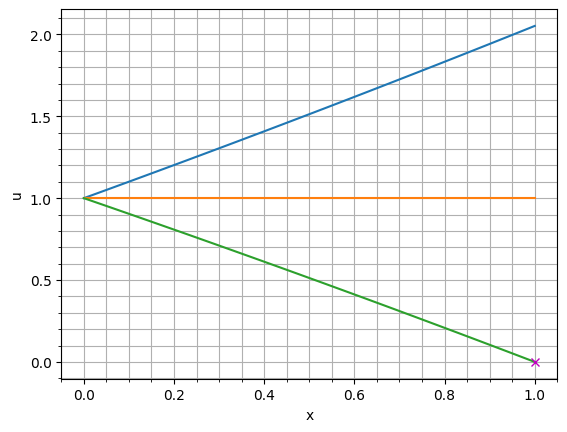

In [4]:
# Parameters
eps = 0.1
x = np.linspace(0,1,101)
e = 0.1 #the peclet number 


# ODE system
def ode_system(x:float,y:np.ndarray)->np.ndarray:
   """
   The system of odes for Eq:1
   where where the equation is:
   -e*d2u/dx2 + du/dx =0

   take:
        y1 = du/dx
        dy1/dx = ey1
   
   the function takes the following arguments: 
   x : float : position at which Y is to be evaluated at 
   y : np.ndarray: the is an array which requires two values in the form [dudx,u] (the initial values)

   the function returns the ode systems in an np.ndarray format
   
   """ 
   y1, y2 = y

   dudx = y2
   dydx = e*y2
   ode = np.array([dudx,dydx])
   return ode


# Boundary conditions for u at x=0 and x=1
u0 =  1 
u1  = 0 

# Shooting method implementation
tol = 1e-5 
max_iter = 100 
#known boundary conditions: 
u_0 = 1         #u(x=0) = 1
u_1 = 0         #u(x=1) = 0

# ---- Implement the shooting method using the secant method as a root-finding technique ----
#initial guess: 
guess = [1,0]     #this is the new guess for the derivatives 

sol0 = scipy.integrate.solve_ivp(ode_system,(x[0],x[-1]), [u_0, guess[0]], t_eval = x)
sol1 = scipy.integrate.solve_ivp(ode_system,(x[0],x[-1]),[u_0,guess[1]],t_eval = x)
y = [sol0.y[0], sol1.y[0]] #save the solutions, this is done so that they can be plotted later

tolerance = 1e-5 

for i in range(max_iter):
   if abs(y[-1][-1]-u_1) < tolerance:
      break  
   
   new_guess = guess[-1] - (y[-1][-1]-u_1) * (guess[-1]-guess[-2])/(y[-1][-1]-y[-2][-1])
   guess.append(new_guess)

   #solve the IVP using the new guess:
   new_sol = scipy.integrate.solve_ivp(ode_system, (x[0],x[-1]), [u0, guess[-1]],t_eval= x)
   y.append(new_sol.y[0])


   

# Extract shooting solution
shooting_solution = y[-2] 

# Analytical solution
def analytical_sol(x:np.ndarray,e:float)->np.ndarray:
   """
   This function defines the analytical solution to the differential equation in Eq.1. 
   The function takes the following terms: 


   And the function returns the u(x) in an np.ndarray format. 
   """
   numerator= np.exp(x/e) - np.exp(1/e)
   denominator = 1- np.exp(1/e)
   return numerator/denominator


analytical_solution = analytical_sol(x,e) 

# Plot results
fig = plt.figure()
for i, y_i in enumerate(y):
   plt.plot(x,y_i,label= f"y_{i}") 
plt.plot(u0, u1, label = 'boundary conditions', linestyle = "", marker = 'x', color = "m")
plt.xlabel('x')
plt.ylabel('u')
plt.minorticks_on()
plt.grid(which= 'both')
plt.show()








In [5]:
grader.check("q1_1")

q1_1 results:
    q1_1 - 1 result:
        ✅ Test case passed

    q1_1 - 2 result:
        ❌ Test case failed
        Trying:
            test_x = 0.5
        Expecting nothing
        ok
        Trying:
            test_y = np.array([1.0, 2.0])
        Expecting nothing
        ok
        Trying:
            expected_output = np.array([2.0, 2.0 / eps])
        Expecting nothing
        ok
        Trying:
            result = ode_system(test_x, test_y)
        Expecting nothing
        ok
        Trying:
            assert isinstance(result, np.ndarray), '`ode_system` must return a NumPy array.'
        Expecting nothing
        ok
        Trying:
            assert np.allclose(result, expected_output), f'`ode_system` output incorrect!'
        Expecting nothing
        **********************************************************************
        Line 6, in q1_1 1
        Failed example:
            assert np.allclose(result, expected_output), f'`ode_system` output incorrect!'
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\olive\AppData\Local\Programs\Python\Python312\Lib\doctest.py", line 1368, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1_1 1[5]>", line 1, in <module>
                assert np.allclose(result, expected_output), f'`ode_system` output incorrect!'
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
            AssertionError: `ode_system` output incorrect!

    q1_1 - 3 result:
        ✅ Test case passed

    q1_1 - 4 result:
        ❌ Test case failed
        Trying:
            assert isinstance(shooting_solution, np.ndarray), '`shooting_solution` must be a NumPy array.'
        Expecting nothing
        ok
        Trying:
            assert shooting_solution.shape == x.shape, '`shooting_solution` must have the same length as `x`.'
        Expecting nothing
        ok
        Trying:
            __shooting_solution = np.array([1.0, 0.999995215, 0.999989927, 0.999984082, 0.999977624, 0.999970485, 0.999962593, 0.999953864, 0.999944222, 0.999933578, 0.999921827, 0.999908848, 0.999894507, 0.999878651, 0.999861116, 0.999841719, 0.999820263, 0.999796535, 0.999770308, 0.999741338, 0.999709319, 0.999673894, 0.999634779, 0.999591627, 0.999544021, 0.999491479, 0.999433448, 0.999369308, 0.999298374, 0.999219888, 0.999133028, 0.999036902, 0.998930551, 0.998812948, 0.998682997, 0.998539536, 0.99838095, 0.998205532, 0.998011886, 0.997798283, 0.997562657, 0.997302605, 0.99701539, 0.996697934, 0.996346827, 0.995958321, 0.995528331, 0.995052436, 0.994525879, 0.993943567, 0.993300068, 0.992589617, 0.99180466, 0.990936164, 0.989977243, 0.988919433, 0.987752586, 0.986464869, 0.985042764, 0.983471067, 0.981732892, 0.979809666, 0.97768113, 0.975325343, 0.972718678, 0.969835821, 0.966649776, 0.963131861, 0.959246155, 0.954946385, 0.950198192, 0.944960017, 0.939181895, 0.932805462, 0.925763949, 0.917982185, 0.909376598, 0.89985521, 0.889317644, 0.877655119, 0.864750451, 0.850478054, 0.834703939, 0.817285715, 0.798048851, 0.776761776, 0.753252764, 0.727316386, 0.69870561, 0.667131794, 0.63226469, 0.593732447, 0.551121603, 0.503977093, 0.451802244, 0.394058777, 0.330166807, 0.259504843, 0.181409787, 0.095176933, 4.8507478e-07])
        Expecting nothing
        ok
        Trying:
            assert np.allclose(shooting_solution, __shooting_solution, rtol=0.01, atol=0.01), ' `shooting_solution` does not match expected values.'
        Expecting nothing
        **********************************************************************
        Line 4, in q1_1 3
        Failed example:
            assert np.allclose(shooting_solution, __shooting_solution, rtol=0.01, atol=0.01), ' `shooting_solution` does not match expected values.'
        Exception raised:
            Traceback (most recent call last):
              File "C:\Users\olive\AppData\Local\Programs\Python\Python312\Lib\doctest.py", line 1368, in __run
      

### Question 1.2: solve_bvp()

Solve the convection-diffusion equation ($\text{Eq.1}$) using the in-built function in scipy [`solve_bvp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html).

Your code should:
- Reuse the parameter $\varepsilon$ `eps`, grid `x` and the ODE system function `ode_system(x,y)` from the previous question.
- Define a boundary condition function `bc(u0,u1)` that returns the residuals of the boundary conditions. Remember to define type hints and docstrings. Here `u0` defines the function value at $x=0$ and `u1` defines the function value at $x=1$.
- Solve the system using `solve_bvp()` and store the resulting solution in the variable `bvp_solution`. Remember to define an initial guess for the `solve_bvp()` function.
- Plot your `bvp_solution` together with the shooting method solution `shooting_solution` obtained in the previous question.  Include a title, legend and axis labels.

In [ ]:
# Define boundary conditions function for solve_bvp
...

# Solve using solve_bvp
...

# Extract bvp solution
bvp_solution = ...

# Plot results
...

In [ ]:
grader.check("q1_2")

### Reflect on the results

The shooting method transforms a boundary value problem (BVP) into an initial value problem (IVP). For small $\epsilon$, the convection–diffusion equation develops a sharp boundary layer near $x = 1$.
1. Explain why this makes the shooting method highly sensitive to the initial slope at $x = 0$, and predict what happens if your guess is even slightly wrong.
2. Would solve_bvp() show the same kind of sensitivity to the initial slope guess? 

Justify your answer in 4–6 sentences in the text box below.



_Type your answer here, replacing this text._

## Question 2

We now solve the same steady one-dimensional convection–diffusion system defined in Question 1:

\begin{equation}
\tag{Eq. 1}
 -\varepsilon\cfrac{\text{d}^2u}{\text{d}x^2}+\cfrac{\text{d}u}{\text{d}x} = 0,
\end{equation}

but with a **Neumann** boundary condition at $x=0$. The new set of boundary conditions are thus defined as: 

\begin{equation}
\tag{Eq. 4}
\frac{du}{dx}\bigg\vert_{x=0}=-0.001, \quad u(x=1)=0.
\end{equation}

### Analytical Solution

The analytical solution for this new set of boundary conditions becomes:

\begin{equation}
\tag{Eq. 3}
 u(x)=-0.001\varepsilon\left(\exp(x/\varepsilon)-\exp(1/\varepsilon)\right)
\end{equation}

### Question 2.1: Shooting Method 

Solve $\text{Eq.1}$, given the new boundary conditions from $\text{Eq.4}$, using the shooting method. 

Your code should:
- Reuse the parameter $\varepsilon$ `eps`, grid `x` and the ODE system function `ode_system(x,y)` from the previous question.
- Impose a Neumann boundary condition $\frac{du}{dx}(x=0)=-0.001$ and a Dirichlet boundary condition $u(x=1)=0$. Store these using variables `du_dx_0` and `u1`.
- Implement the shooting method using the **secant method** as a root-finding technique and using the same tolerance `tol=1e-5` and maximum iteration count `max_iter=100` as in Question 1.
- Store the converged numerical solution in the variable `shooting_solution2`. 
- Compute and store the analytical solution in the variable `analytical_solution2`. 
- Make a plot of the numerical solution against the analytical solution. Include a title, legend and axis labels.

In [ ]:
# Boundary conditions
du_dx_0 = ...
u1 = ...

# Shooting method implementation for Neumann BC
...

# Extract shooting solution
shooting_solution2 = ...

# Analytical solution
analytical_solution2 = ...

# Plot results
...

In [ ]:
grader.check("q2_1")

### Question 2.2: solve_bvp()

Solve $\text{Eq.1}$, given the new boundary conditions from $\text{Eq.4}$, using the in-built function in scipy [`solve_bvp()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html).

Your code should:
- Reuse the parameter $\varepsilon$ `eps`, grid `x` and the ODE system function `ode_system(x,y)` from the previous question.
- Define a boundary condition function `bc2(u0,u1)` that returns the residuals of the boundary conditions. Remember to define type hints and docstrings. Here `u0` defines the function value at $x=0$ and `u1` defines the function value at $x=1$.
- Solve the system using `solve_bvp()` and store the resulting solution in the variable `bvp_solution2`. Remember to define an initial guess for the `solve_bvp()` function.
- Plot your `bvp_solution2` together with the shooting method solution `shooting_solution2` obtained in the previous question.  Include a title, legend and axis labels.

In [ ]:
# Define boundary conditions function for solve_bvp with Neumann BC
...

# Solve using solve_bvp
...

# Extract bvp solution
bvp_solution2 = ...

# Plot results
...

In [ ]:
grader.check("q2_2")

## Bonus Question 3

Solve $\text{Eq.1}$, using the same boundary conditions from Question 1 given in $\text{Eq.2}$, with the finite difference method. As in Assignment 6, construct the coefficient matrix $A$ so that you solve only for the unknown points of $u(x)$.

Your code should:
- Reuse the parameter $\varepsilon$ `eps` and grid `x` from the previous questions.
- Store the numerical solution $u(x)$ obtained using the finite difference method in the variable `u_fd`. 
- Plot your numerical solution together with the analytical solution computed earlier (`analytical_solution`).  Include a title, legend and axis labels.

**NOTE**: For this question, only grader checks for the final solution `u_fd` are implemented.

In [ ]:
# Finite Difference Method Implementation
...

# Plot results
...

In [ ]:
grader.check("q3_1")